### In this notebook, I directly dropped the columns with null values. And the AUC score increased to 55%

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

In [2]:
df_train = pd.read_csv("2020_Competition_Training (1).csv")
df_train["train"] = 1
df_test = pd.read_csv("2020_Competition_Holdout .csv")
df_test["train"] = 0
df_test["transportation_issues"] = "NA"
df = pd.concat([df_train, df_test])
df.reset_index(inplace=True)

df.shape #87253 rows with 828 features
#df.drop("person_id_syn", axis=1, inplace=True)
#df= pd.get_dummies(df)
#df.fillna(0,inplace=True)

/Users/zixuanzhang/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (80,193) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/zixuanzhang/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (79) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(87253, 828)

In [3]:
#df.to_csv("merge_data.csv")

In [4]:
df_columns = df.columns.tolist()
df_columns.remove("transportation_issues")

In [5]:
df_train = df[df["train"]==1]
df_train.dropna(axis=1,inplace=True)
df_hold = df[df["train"]==0]

y = df_train["transportation_issues"].values
y = y.astype("int")
x = df_train.drop(["index","person_id_syn","transportation_issues"], axis=1)
x = pd.get_dummies(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

/Users/zixuanzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

### Traning

In [10]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 2 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  7.3min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 12.2min finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [11]:
y_pred = rf_random.predict(x_test)

In [12]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))
(y_test==y_pred).mean() #accuracy 85.59%

#False negative values are larger than the false positive values.

[[17802    37]
 [ 2970    63]]


0.8559313913376773

In [16]:
y_pred.mean()
y_test.mean()

0.14531429666538903

In [13]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.509348703030053

ROC_AUC Score:
0.509348703030053


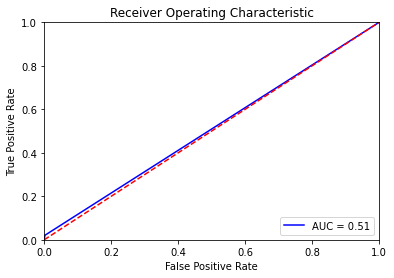

In [14]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

print("ROC_AUC Score:")
print(roc_auc_score(y_test, y_pred))

#ROC Plot
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()